<a href="https://colab.research.google.com/github/ArturoAA95/TransmisionProblem/blob/main/TestTransmision2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [257]:
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from random import randint
import sys
import os
import scipy
from scipy.optimize import root_scalar
from scipy.optimize import brentq
from scipy.sparse.linalg import spsolve
import heapq

In [258]:
def H(a1, a2, a3, a4):
  return min(a1, a2, a3, a4) + 1

def S(a1, a2, a3, a4):
  return .25*(a1+a2+a3+a4)

def G(z, a1, a2, a3, a4):
  return np.sqrt(max( 0, z-a1, z-a2)**2 + max(0, z-a3, z-a4)**2 ) - .2

#def G_Anis(z, a1, a2, a3, a4):
#  aux = max(0, z-a3, z-a4)
#  if aux
#  return np.sqrt( /  )

def FindZero(a1, a2, a3, a4, G):
  # Find the root of G(z) = 0
  sol = brentq(G, args=(a1, a2, a3, a4), a=min(a1, a2, a2, a4), b = min(a1, a2, a2, a4)+ 1)
  #sol = root_scalar(G, args=(a1, a2, a3, a4), method='secant', x0=min(a1, a2, a2, a4), x1=min(a1, a2, a2, a4)+1, xtol = .0001).root #30s
  return sol


print(FindZero(1, 2, 3, np.inf, G))

1.2


#Fast Marching Method

In [259]:
def InitializeNarrowBand(NB, om, dist, N, H):
  for i in range(N):
    for j in range(N):
      if om[i, j] > 0 and om[i, j] < 3: #Run over eikonal
        if om[i+1, j] == 0:
            aux = H(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1])
        elif om[i-1, j] == 0:
            aux = H(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1])
        elif om[i, j+1] == 0:
            aux = H(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1])
        elif om[i, j-1] == 0:
            aux = H(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1])
        else:
          continue  #The index is not added to the narrow band
        new_dist = np.copy(aux)
        if new_dist < dist[i, j]:
          dist[i, j] = new_dist
          x = [i, j]
          heapq.heappush(NB, (new_dist, x))

def UpdateDistance(NB, om, dist, N, H, i_aux, j_aux):
    #Update the distance of i_aux, j_aux
    new_dist = H(dist[i_aux+1, j_aux], dist[i_aux-1, j_aux], dist[i_aux, j_aux+1], dist[i_aux, j_aux-1])
    #Only update if the distance is smaller than the current distance
    if new_dist < dist[i_aux, j_aux]:
        dist[i_aux, j_aux] = new_dist
        heapq.heappush(NB, (new_dist, [i_aux, j_aux]))


def FastMarchingMethod2D(NB, om, dist, N, H): #Solves Eikonal equation
  #Inicialice narrow band
  InitializeNarrowBand(NB, om, dist, N, H)
  #Compute solution
  #Loop until narrow band is empty
  while len(NB)>0 :
    #Pop the element with the least distance in the narrow band
    c_dist, c_vert = heapq.heappop(NB)
    i = int(c_vert[0])
    j = int(c_vert[1])
    #The vertex (i,j) becomes a boundary point
    om[i, j] = 0
    # Check if we have already poped the vertex
    if c_dist > dist[i, j]:
      continue
    #Update distance for neighbors of current_vertex
    #Update the distance of the neighbor upwards
    if om[i+1, j] > 0 and om[i+1, j] < 3: #Restrict to Eikonal
      i_aux = i+1
      j_aux = j
      UpdateDistance(NB, om, dist, N, H, i_aux, j_aux)
    #Update the distance of the neighbor downwards
    if om[i-1, j] > 0 and om[i-1, j] < 3: #Restrict to Eikonal
      i_aux = i-1
      j_aux = j
      UpdateDistance(NB, om, dist, N, H, i_aux, j_aux)
    #Update the distance of the neighbor to the right
    if om[i, j+1] > 0 and om[i, j+1] < 3: #Restrict to Eikonal
      i_aux = i
      j_aux = j+1
      UpdateDistance(NB, om, dist, N, H, i_aux, j_aux)
    #Update the distance of the neighbor to the left
    if om[i, j-1] > 0 and om[i, j-1] < 3: #Restrict to Eikonal
      i_aux = i
      j_aux = j-1
      UpdateDistance(NB, om, dist, N, H, i_aux, j_aux)
  #Return the distance matrix
  return dist


#Generalized Fast Marching Method

In [260]:
def InitializeNarrowBandG(NB, om, dist, N, H):
  for i in range(N):
    for j in range(N):
      if om[i, j] > 0 and om[i, j] < 3: #Run over eikonal
        if om[i+1, j] == 0:
            aux = FindZero(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1], H)
        elif om[i-1, j] == 0:
            aux = FindZero(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1], H)
        elif om[i, j+1] == 0:
            aux = FindZero(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1], H)
        elif om[i, j-1] == 0:
            aux = FindZero(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1], H)
        else:
          continue  #The index is not added to the narrow band
        new_dist = np.copy(aux)
        if new_dist < dist[i, j]:
          dist[i, j] = new_dist
          x = [i, j]
          heapq.heappush(NB, (new_dist, x))

def UpdateDistanceG(NB, om, dist, N, H, i_aux, j_aux):
    #Update the distance of i_aux, j_aux
    new_dist = FindZero(dist[i_aux+1, j_aux], dist[i_aux-1, j_aux], dist[i_aux, j_aux+1], dist[i_aux, j_aux-1], H)
    #Only update if the distance is smaller than the current distance
    if new_dist < dist[i_aux, j_aux]:
        dist[i_aux, j_aux] = new_dist
        heapq.heappush(NB, (new_dist, [i_aux, j_aux]))


def FastMarchingMethod2DG(NB, om, dist, N, H): #Solves Eikonal equation
  #Inicialice narrow band
  InitializeNarrowBandG(NB, om, dist, N, H)
  #Compute solution
  #Loop until narrow band is empty
  while len(NB)>0 :
    #Pop the element with the least distance in the narrow band
    c_dist, c_vert = heapq.heappop(NB)
    i = int(c_vert[0])
    j = int(c_vert[1])
    #The vertex (i,j) becomes a boundary point
    om[i, j] = 0
    # Check if we have already poped the vertex
    if c_dist > dist[i, j]:
      continue
    #Update distance for neighbors of current_vertex
    #Update the distance of the neighbor upwards
    if om[i+1, j] > 0 and om[i+1, j] < 3: #Restrict to Eikonal
      i_aux = i+1
      j_aux = j
      UpdateDistanceG(NB, om, dist, N, H, i_aux, j_aux)
    #Update the distance of the neighbor downwards
    if om[i-1, j] > 0 and om[i-1, j] < 3: #Restrict to Eikonal
      i_aux = i-1
      j_aux = j
      UpdateDistanceG(NB, om, dist, N, H, i_aux, j_aux)
    #Update the distance of the neighbor to the right
    if om[i, j+1] > 0 and om[i, j+1] < 3: #Restrict to Eikonal
      i_aux = i
      j_aux = j+1
      UpdateDistanceG(NB, om, dist, N, H, i_aux, j_aux)
    #Update the distance of the neighbor to the left
    if om[i, j-1] > 0 and om[i, j-1] < 3: #Restrict to Eikonal
      i_aux = i
      j_aux = j-1
      UpdateDistanceG(NB, om, dist, N, H, i_aux, j_aux)
  #Return the distance matrix
  return dist


#Interfase functions

In [261]:
def f(i):
  return 80+int(15*np.sin((i+30)/30))

#Test building domain

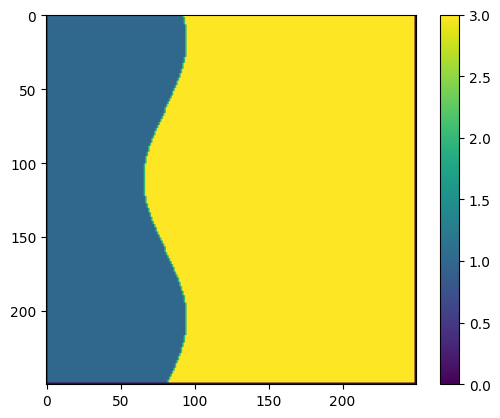

In [262]:
def CreateInterfase(om, k, N, f):
  for i in range(1, N-1):
    om[i, f(i)] = k

def Build_Eik_Brown(om, N):
  for i in range (1, N-1):
    j = 1
    while om[i,j] != 2 and j<N-1: #Eikonal
      om[i,j] = 1
      j = j+1
    j = j+1
    while j < N-1:  #Brownian
      om[i,j] = 3
      j = j+1

N = 250

#We give codes to each region of the domain
# 0 -> Fixed point (Boundary and non-used)
# 1 -> Eikonal
# 2 -> Interface
# 3 -> Brownian

om = np.zeros((N,N))
#Construction of Interface
CreateInterfase(om, 2, N, f)
#Construction of Domain
Build_Eik_Brown(om, N)

plt.imshow(om)
plt.colorbar()

#Test fast marching method

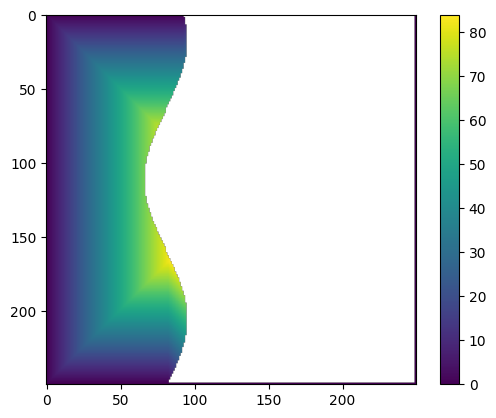

In [263]:
def InitializeDistances(om, N):
   dist = np.zeros((N,N))
   for i in range(N):
    for j in range(N):
       if om[i, j] > 0:
          dist[i, j] = np.inf
   return dist

Omega = np.copy(om)   ### We preserve the structure of the domain
dist = InitializeDistances(om, N)
NB = []
eik_0 = FastMarchingMethod2D(NB, Omega, dist, N, H)        ### Omega is modified
plt.imshow(eik_0)
plt.colorbar()

#Brownian system

In [264]:
from scipy import sparse

def HashTablesBrownian(om, N):
  #Create hash tables for Brownian
  C_to_P = {}
  P_to_C = {}
  dim = 0
  for i in range(N):
    for j in range(N):
      if om[i,j] == 3:
        C_to_P[i,j] = dim
        P_to_C[dim] = [i,j]
        dim = dim + 1
  return C_to_P, P_to_C, dim

#Give coordinates and receive position in vector
def Coord_to_Pos(x, y, C_to_P):
  return C_to_P[x,y]

#Give position in vector and receive coordinates
def Pos_to_Coord(l, P_to_C):
  return P_to_C[l]

def CreateMatrixBrownian(C_to_P, P_to_C, dim, om):
  #Create sparse matrix for Brownian
  A = sparse.csr_matrix((dim, dim))
  A = A.tolil()

  #Construct linear system for the Brownian region
  for l in range(dim):
    A[l,l] = -4
    x, y = Pos_to_Coord(l, P_to_C)
    #Check if (x,y) has a neighbor to the left and if it's in the Brownian region
    if om[x, y-1] == 3:
      A[l, Coord_to_Pos(x, y-1, C_to_P)] = 1
    #Check if (x,y) has a neighbor to the right and if it's in the Brownian region
    if om[x, y+1] == 3:
      A[l, Coord_to_Pos(x, y+1, C_to_P)] = 1
    #Check if (x,y) has a neighbor upwards and if it's in the Brownian region
    if om[x-1, y] == 3:
      m = Coord_to_Pos(x-1, y, C_to_P)
      A[l, m] = 1
    #Check if (x,y) has a neighbor downwards and if it's in the Brownian region
    if om[x+1, y] == 3:
      m = Coord_to_Pos(x+1, y, C_to_P)
      A[l, m] = 1

  A = A.tocsr()
  return A

#Functions to update Interfase
def Update_b(sol, CtoP, dim, om, f, N):
  b = np.zeros(dim)
  for i in range(1, N-1):
    x = i
    y = f(i)
    l = Coord_to_Pos(x, y+1, CtoP)
    b[l] = b[l] - sol[x, y]
    if om[x+1, y+1] != 3:
      b[l] = b[l] - sol[x+1, y+1]
    if om[x-1, y+1] != 3:
      b[l] = b[l] - sol[x-1, y+1]
  return b

#Receives vector obtained when solving Laplaces equation and copies it to the solution matrix
def Update_sol_I(sol, sol_brow, dim, N, CtoP, f):
  for i in range(1, N-1):
    x = i
    y = f(i)
    l = Coord_to_Pos(x, y+1, CtoP)
    sol[x, y+1] = sol_brow[l]
  return sol

def Update_sol(sol, sol_brow, dim, PtoC):
  for l in range(dim):
    x, y = Pos_to_Coord(l, PtoC)
    sol[x, y] = sol_brow[l]
  return sol

#Test Brownian system

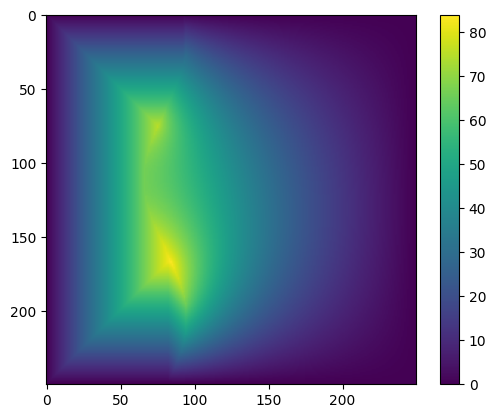

In [265]:
C_to_P, P_to_C, dim = HashTablesBrownian(om, N)
A = CreateMatrixBrownian(C_to_P, P_to_C, dim, Omega)

#Initialize solution
b = Update_b(eik_0, C_to_P, dim, om, f, N)

#Actualiza_b(sol_0, dim, Iy, vT, hT, N)
x = spsolve(A, b)
sol = Update_sol(eik_0, x, dim, P_to_C)
#sol = Update_sol(eik_0, x, dim, N, C_to_P, f)
plt.imshow(sol)
plt.colorbar()

st = np.copy(sol)

#Interface
CreateInterfase(om, 2, N, f)